In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
# Retina display
%config InlineBackend.figure_format = 'retina'


In [2]:
from tueplots import bundles
plt.rcParams.update(bundles.beamer_moml())


# Also add despine to the bundle using rcParams
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Increase font size to match Beamer template
plt.rcParams['font.size'] = 16
# Make background transparent
plt.rcParams['figure.facecolor'] = 'none'

In [3]:
train = pd.read_csv(
    "https://gist.githubusercontent.com/ucals/"
    "2cf9d101992cb1b78c2cdd6e3bac6a4b/raw/"
    "43034c39052dcf97d4b894d2ec1bc3f90f3623d9/"
    "osic_pulmonary_fibrosis.csv"
)
train.head()

,Patient,Weeks,FVC,Percent,Age,Sex,SmokingStatus
0,ID00007637202177411956430,-4,2315,58.253649,79,Male,Ex-smoker
1,ID00007637202177411956430,5,2214,55.712129,79,Male,Ex-smoker
2,ID00007637202177411956430,7,2061,51.862104,79,Male,Ex-smoker
3,ID00007637202177411956430,9,2144,53.950679,79,Male,Ex-smoker
4,ID00007637202177411956430,11,2069,52.063412,79,Male,Ex-smoker


In [4]:
train.describe()

,Weeks,FVC,Percent,Age
count,1549.000000,1549.000000,1549.000000,1549.000000
mean,31.861846,2690.479019,77.672654,67.188509
std,23.247550,832.770959,19.823261,7.057395
min,-5.000000,827.000000,28.877577,49.000000
25%,12.000000,2109.000000,62.832700,63.000000
50%,28.000000,2641.000000,75.676937,68.000000
75%,47.000000,3171.000000,88.621065,72.000000
max,133.000000,6399.000000,153.145378,88.000000


In [5]:
# Number of unique patients
train['Patient'].nunique()

176

<AxesSubplot:ylabel='Frequency'>

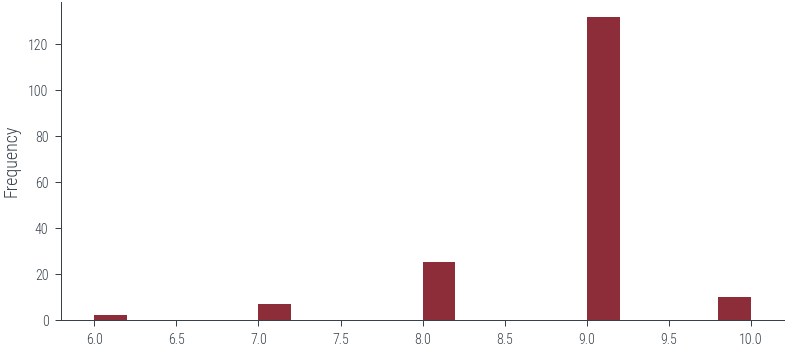

In [6]:
#Number of records per patient
train['Patient'].value_counts().plot(kind='hist', bins=20)

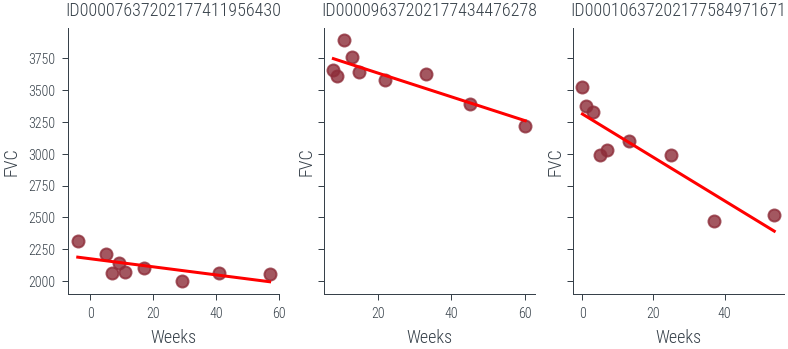

In [7]:
def chart_patient(patient_id, ax):
    data = train[train["Patient"] == patient_id]
    x = data["Weeks"]
    y = data["FVC"]
    ax.set_title(patient_id)
    sns.regplot(x=x, y=y, ax=ax, ci=None, line_kws={"color": "red"})


f, axes = plt.subplots(1, 3, sharey=True)
chart_patient("ID00007637202177411956430", axes[0])
chart_patient("ID00009637202177434476278", axes[1])
chart_patient("ID00010637202177584971671", axes[2])

In [8]:
try:
    import pyro
except ImportError:
    %pip install pyro-ppl

### Pooled model

$\alpha \sim \text{Normal}(0, 1)$

$\beta \sim \text{Normal}(0, 1)$

$\sigma \sim \text{HalfNormal}(100)$

$FVC_i \sim \text{Normal}(\alpha + \beta \cdot Week_i, \sigma)$



In [9]:
def pooled_model(sample_weeks, fvc):
    a = pyro.sample("a", pyro.distributions.Normal(0., 100.))
    b = pyro.sample("b", pyro.distributions.Normal(0., 100.))
    sigma = pyro.sample("sigma", pyro.distributions.HalfNormal(10.))
    with pyro.plate("samples", len(sample_weeks)):
        fvc = pyro.sample("fvc", pyro.distributions.Normal(a + b * sample_weeks, sigma), obs=fvc)
    return fvc

In [10]:
# Convert NumPy arrays to PyTorch tensors
sample_weeks = torch.tensor(train["Weeks"].values, dtype=torch.float32)
fvc = torch.tensor(train["FVC"].values, dtype=torch.float32)

In [11]:
sample_weeks.shape

torch.Size([1549])

/home/nipun.batra/miniforge3/lib/python3.9/site-packages/torch/random.py:107: UserWarning: CUDA reports that you have 4 available devices, and you have used fork_rng without explicitly specifying which devices are being used. For safety, we initialize *every* CUDA device by default, which can be quite slow if you have a lot of GPUs.  If you know that you are only making use of a few CUDA devices, set the environment variable CUDA_VISIBLE_DEVICES or the 'devices' keyword argument of fork_rng with the set of devices you are actually using.  For example, if you are using CPU only, set CUDA_VISIBLE_DEVICES= or devices=[]; if you are using GPU 0 only, set CUDA_VISIBLE_DEVICES=0 or devices=[0].  To initialize all devices and suppress this warning, set the 'devices' keyword argument to `range(torch.cuda.device_count())`.
  warnings.warn(


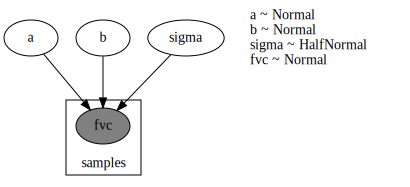

In [12]:
# Render the model graph
data = (train["Weeks"].values, train["FVC"].values)
pyro.render_model(pooled_model, model_kwargs={"sample_weeks": sample_weeks, "fvc": fvc}, 
                render_distributions=True,
                render_params=True,
                )

In [13]:
from sklearn.preprocessing import LabelEncoder

patient_encoder = LabelEncoder()
train["patient_code"] = patient_encoder.fit_transform(train["Patient"].values)

In [14]:
patient_code = torch.tensor(train["patient_code"].values, dtype=torch.float32)

In [16]:
from pyro.infer import MCMC, NUTS, Predictive

In [17]:
nuts_kernel = NUTS(pooled_model)

mcmc = MCMC(nuts_kernel, num_samples=2000, warmup_steps=1000, num_chains=1)

In [18]:
mcmc.run(sample_weeks, fvc)

Sample: 100%|██████████| 3000/3000 [00:39, 75.25it/s, step size=4.63e-01, acc. prob=0.929] 


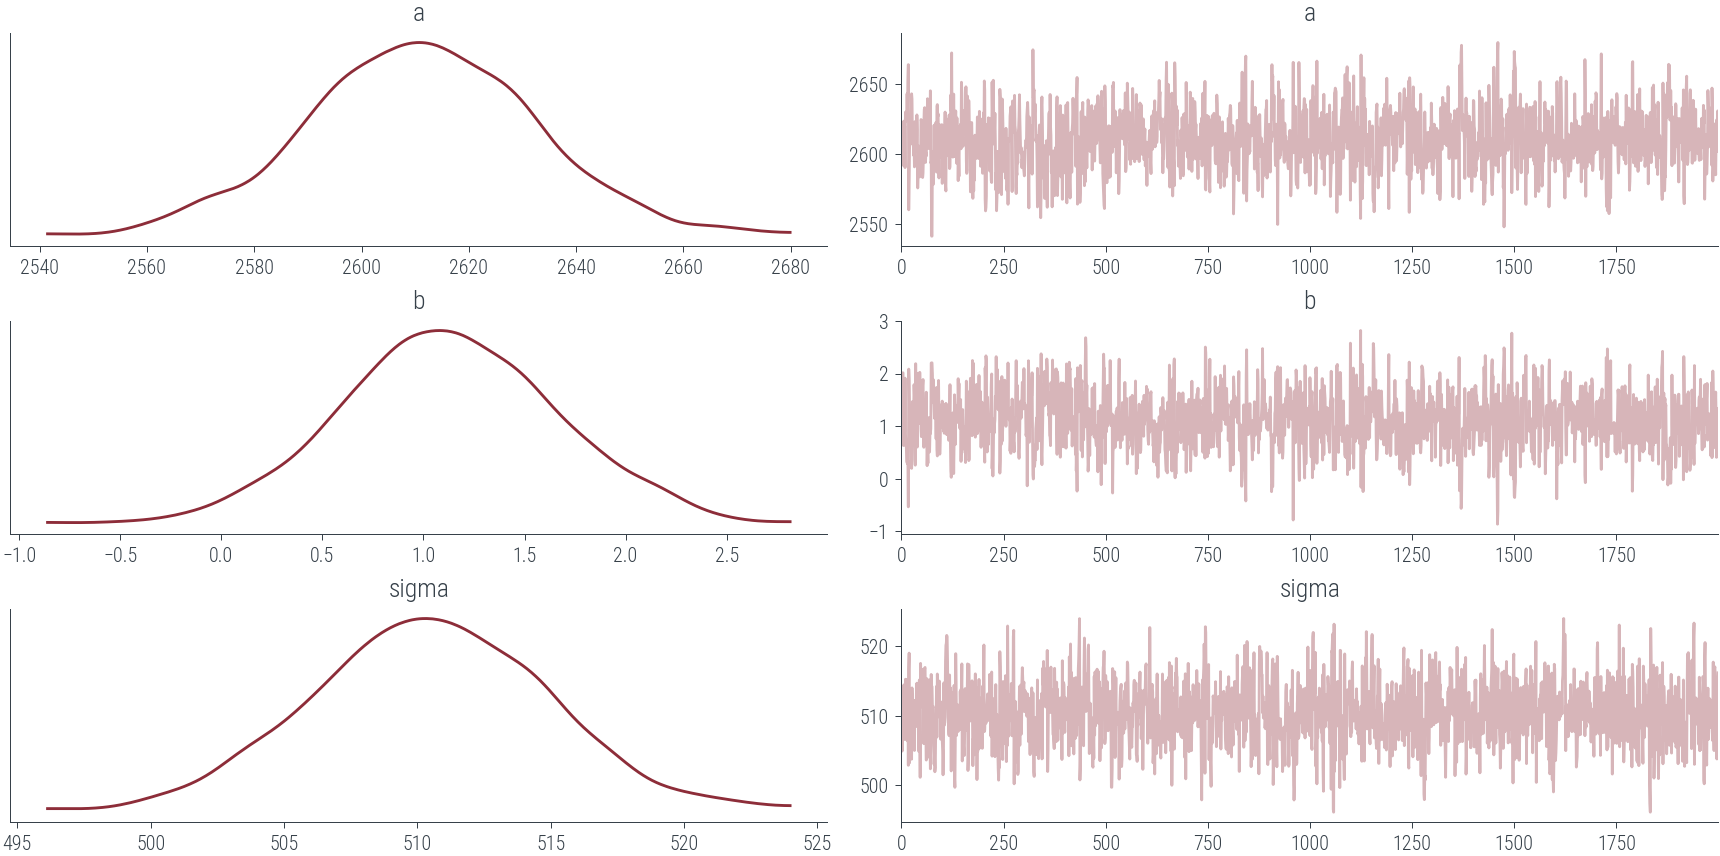

In [19]:
import arviz as az

data = az.from_pyro(mcmc)
az.plot_trace(data, compact=True);

In [31]:
mcmc.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a   2611.03     21.25   2610.91   2575.81   2647.13    910.35      1.00
         b      1.12      0.54      1.12      0.24      2.05    875.53      1.00
     sigma    510.47      4.48    510.46    503.09    517.66   1128.30      1.00

Number of divergences: 0


In [32]:
# Predictive distribution
predictive = Predictive(pooled_model, mcmc.get_samples())


In [33]:
predictive

Predictive()

In [34]:
# Predictive distribution
#predictive = Predictive(pooled_model, num_samples=2000)

In [35]:
all_weeks = torch.arange(-12, 134, 1)
predictions = predictive(all_weeks, None)

<AxesSubplot:>

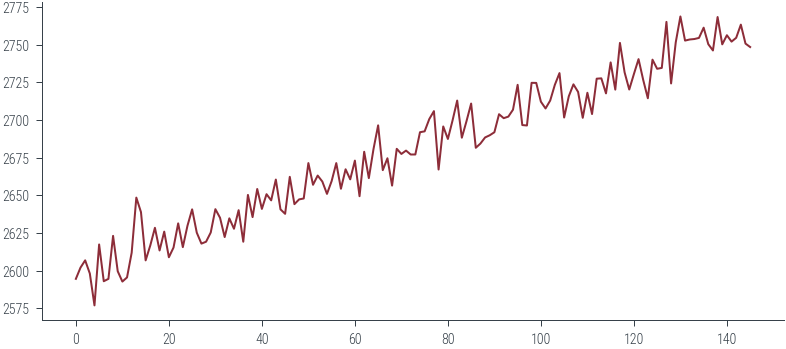

In [36]:
pd.DataFrame(predictions["fvc"]).mean().plot()

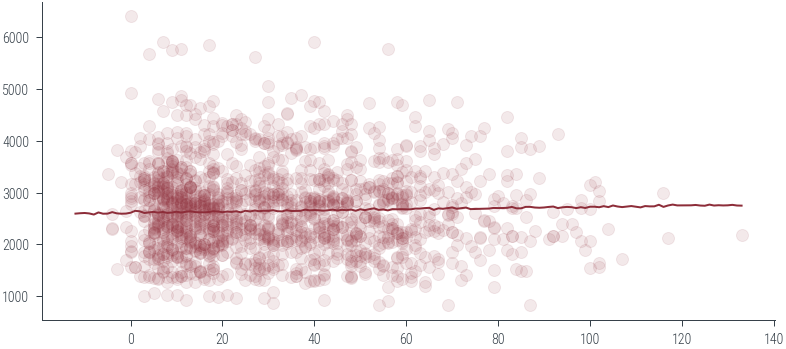

In [37]:
plt.plot(all_weeks, predictions["fvc"].mean(dim=0))
plt.scatter(sample_weeks, fvc, alpha=0.1)

Text(0, 0.5, 'FVC')

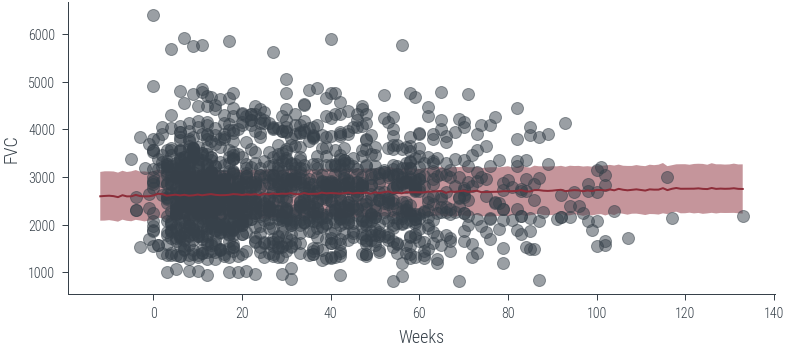

In [38]:
# Get the mean and standard deviation of the predictions
mu = predictions["fvc"].mean(dim=0)
sigma = predictions["fvc"].std(dim=0)

# Plot the predictions
plt.plot(all_weeks, mu)
plt.fill_between(all_weeks, mu - sigma, mu + sigma, alpha=0.5)
plt.scatter(sample_weeks, fvc, alpha=0.5)
plt.xlabel("Weeks")
plt.ylabel("FVC")

In [40]:
# Unpooled model
def unpool_model(sample_weeks, patient_code, fvc=None):
    sigma = pyro.sample("sigma", pyro.distributions.HalfNormal(10.))
    with pyro.plate("patients", patient_code.max() + 1):
        a_p = pyro.sample("a_p", pyro.distributions.Normal(0, 100.))
        b_p = pyro.sample("b_p", pyro.distributions.Normal(0, 100.))
    with pyro.plate("samples", len(sample_weeks)):
        fvc = pyro.sample("fvc", pyro.distributions.Normal(a_p[patient_code] + b_p[patient_code] * sample_weeks, sigma), obs=fvc)
    return fvc

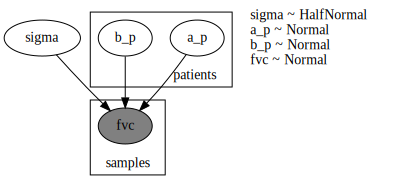

In [43]:
# Render the model graph
data = (torch.tensor(train["Weeks"].values), 
        torch.tensor(train["patient_code"].values), 
        torch.tensor(train["FVC"].values))
# torchify the data
pyro.render_model(unpool_model, model_args=data, 
                render_distributions=True,
                render_params=True,
                )

In [44]:
nuts_kernel_unpooled = NUTS(unpool_model)

mcmc_unpooled = MCMC(nuts_kernel_unpooled, num_samples=2000, warmup_steps=1000, num_chains=1)

In [45]:
mcmc_unpooled.run(*data)

Sample: 100%|██████████| 3000/3000 [03:54, 12.77it/s, step size=2.88e-01, acc. prob=0.874]


/home/nipun.batra/miniforge3/lib/python3.9/site-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


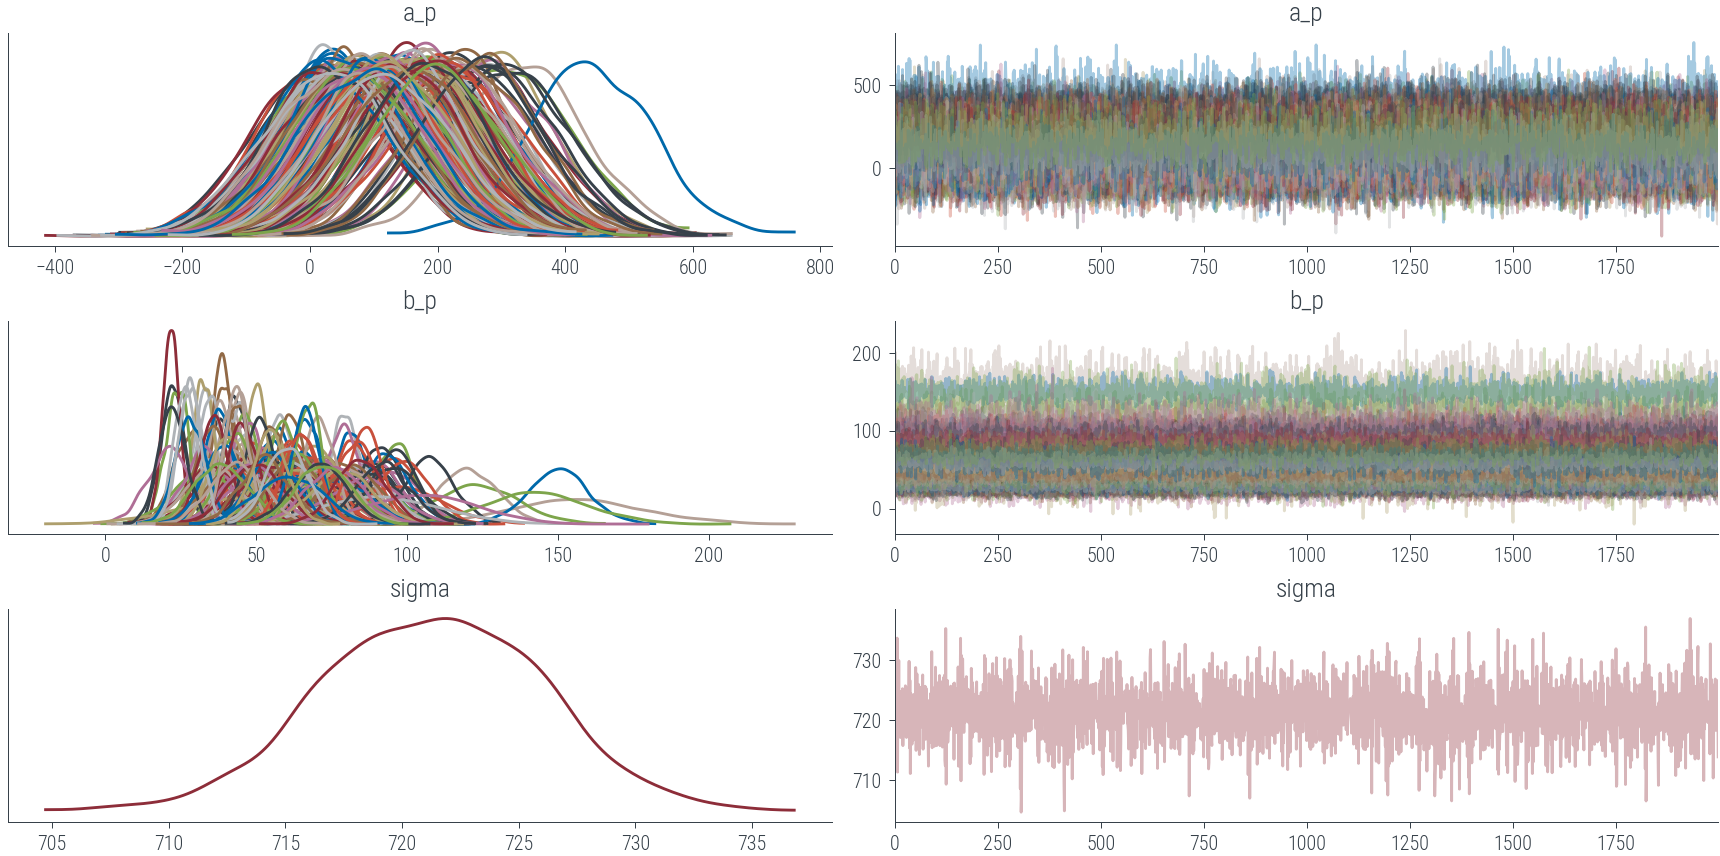

In [46]:
az.plot_trace(az.from_pyro(mcmc_unpooled), compact=True);

In [47]:
# Predictive distribution for unpooled model

predictive_unpooled = Predictive(unpool_model, mcmc_unpooled.get_samples())


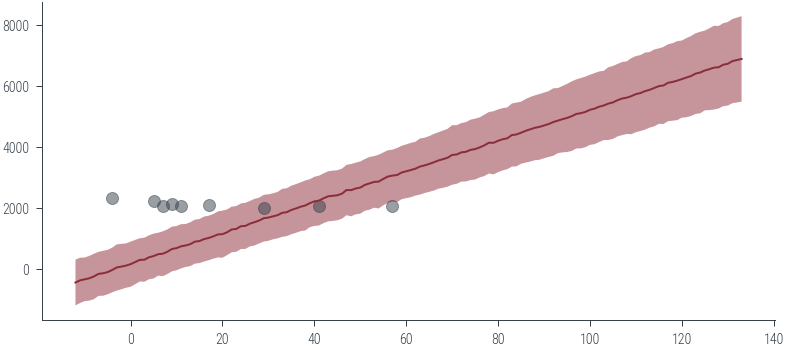

In [48]:
# Predictive distribution for unpooled model for all weeks for a given patient

all_weeks = torch.arange(-12, 134, 1)
def predict_unpooled(patient_code):
    predictions = predictive_unpooled(all_weeks, patient_code)
    mu = predictions["fvc"].mean(dim=0)
    sigma = predictions["fvc"].std(dim=0)
    return mu, sigma

# Plot the predictions for a given patient
patient_code = torch.tensor([0])
mu, sigma = predict_unpooled(patient_code)
plt.plot(all_weeks, mu)
plt.fill_between(all_weeks, mu - sigma, mu + sigma, alpha=0.5)
plt.scatter(sample_weeks[train["patient_code"] == 0], fvc[train["patient_code"] == 0], alpha=0.5)

In [103]:
dd# mean squared error
mse = np.mean((predictions["fvc"].mean(dim=0) - fvc)**2)
print(f"Mean squared error: {mse:.2f}")

TypeError: mean() received an invalid combination of arguments - got (dtype=NoneType, out=NoneType, axis=NoneType, ), but expected one of:
 * (*, torch.dtype dtype)
 * (tuple of ints dim, bool keepdim, *, torch.dtype dtype)
 * (tuple of names dim, bool keepdim, *, torch.dtype dtype)


In [75]:
def create_prediction_template(unique_patient_df, weeks_series):
    unique_patient_df["_temp"] = True
    weeks = pd.DataFrame(weeks_series, columns=["Weeks"])
    weeks["_temp"] = True
    return unique_patient_df.merge(weeks, on="_temp").drop(["_temp"], axis=1)

patients = train[["Patient", "patient_code"]].drop_duplicates()
start_week_number = -12
end_week_number = 134
predict_weeks = pd.Series(np.arange(start_week_number, end_week_number))
pred_template = create_prediction_template(patients, predict_weeks)


In [70]:
# Predictive distribution

predictive = Predictive(pooled_model, posterior, num_samples=1000)

In [78]:
predictive_samples = predictive(sample_weeks, None)

In [82]:
predictive_samples['fvc'].shape

torch.Size([1000, 9])

In [84]:
sample_weeks

tensor([-4.,  5.,  7.,  9., 11., 17., 29., 41., 57.])

In [83]:
sample_weeks.shape

torch.Size([9])

In [72]:
# Predict FVC for the first patient
patient_id = "ID00007637202177411956430"
patient_data = train[train["Patient"] == patient_id]

# Convert NumPy arrays to PyTorch tensors
sample_weeks = torch.tensor(patient_data["Weeks"].values, dtype=torch.float32)
fvc = torch.tensor(patient_data["FVC"].values, dtype=torch.float32)

predictions = predictive(sample_weeks, fvc)


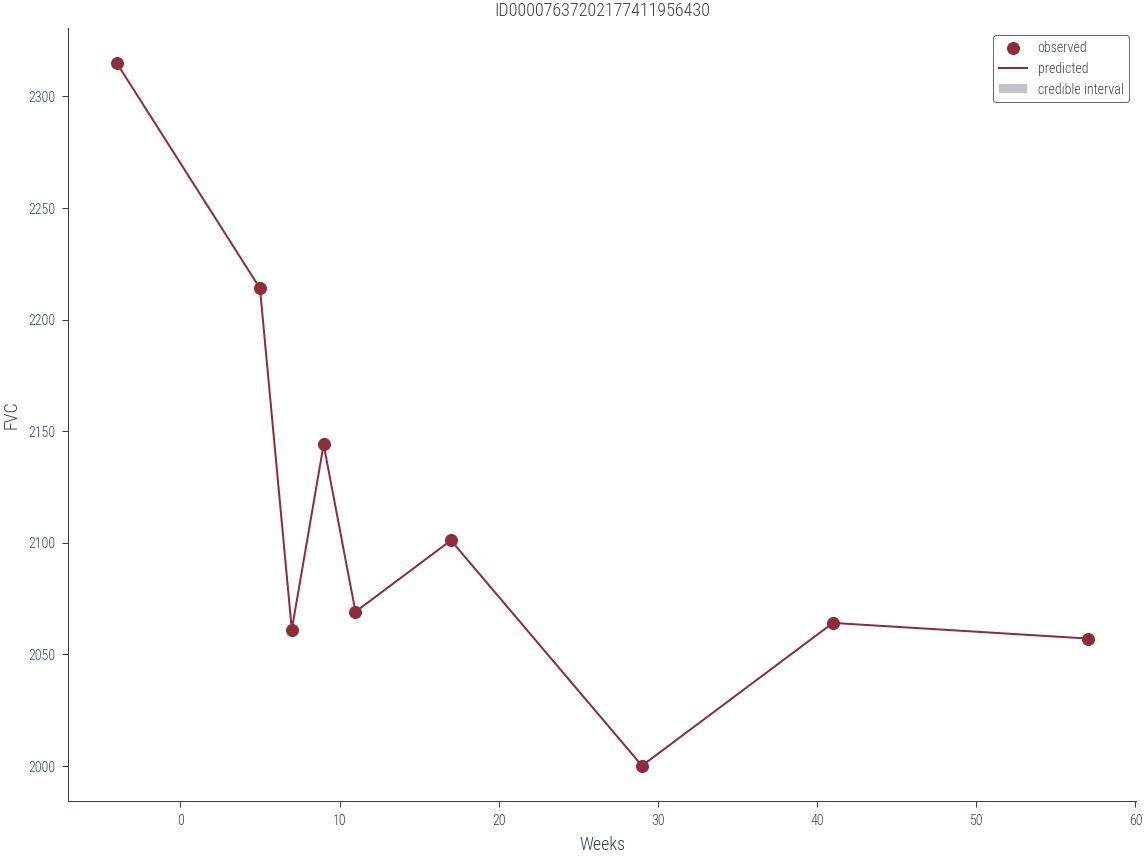

In [74]:
# Plot the predictions
plt.figure(figsize=(8, 6))
plt.scatter(sample_weeks, fvc, label="observed")
plt.plot(sample_weeks, predictions["fvc"].mean(0), label="predicted")
plt.fill_between(sample_weeks, 
                 predictions["fvc"].mean(0) - 3 * predictions["fvc"].std(0), 
                 predictions["fvc"].mean(0) + 3 * predictions["fvc"].std(0), 
                 alpha=0.3, label="credible interval")
plt.legend()
plt.xlabel("Weeks")
plt.ylabel("FVC")
plt.title(patient_id);


In [24]:
c1 = torch.distribution`as.Normal(80, 10)
c2 = torch.distributions.Normal(70, 10)
c3 = torch.distributions.Normal(90, 5)

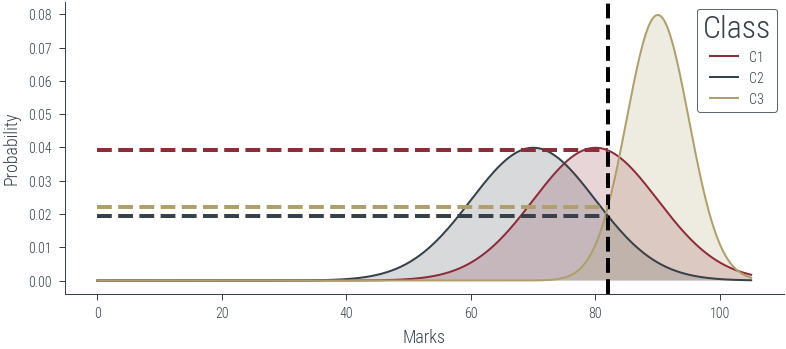

In [5]:
# Plot the distributions
x = torch.linspace(0, 105, 1000)
plt.plot(x, c1.log_prob(x).exp(), label='C1')
plt.plot(x, c2.log_prob(x).exp(), label='C2')
plt.plot(x, c3.log_prob(x).exp(), label='C3')
# Fill the area under the curve
plt.fill_between(x, c1.log_prob(x).exp(), alpha=0.2)
plt.fill_between(x, c2.log_prob(x).exp(), alpha=0.2)
plt.fill_between(x, c3.log_prob(x).exp(), alpha=0.2)

plt.xlabel('Marks')
plt.ylabel('Probability')

plt.legend(title='Class')
plt.savefig('../figures/mle/mle-example.pdf', bbox_inches='tight')

# Vertical line at x = 85
marks = torch.tensor([82.])
plt.axvline(marks.item(), color='k', linestyle='--', lw=2)
# Draw horizontal line to show the probability at x = 85
plt.hlines(c1.log_prob(marks).exp(), 0, marks.item(), color='C0', linestyle='--', lw=2)
plt.hlines(c2.log_prob(marks).exp(), 0, marks.item(), color='C1', linestyle='--', lw=2)
plt.hlines(c3.log_prob(marks).exp(), 0, marks.item(), color='C2', linestyle='--', lw=2)
plt.savefig('../figures/mle/mle-example-2.pdf', bbox_inches='tight')


Text(0, 0.5, 'Likelihood $p(x = 20|\\mu$)')

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive


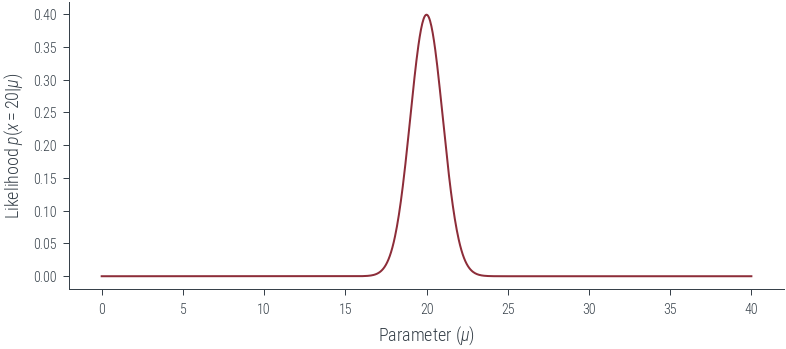

In [6]:
obs = torch.tensor([20.0])
sigma = torch.tensor([1.0])

# Plot the likelihood
mus = torch.linspace(0, 40, 1000)
plt.plot(mus, torch.distributions.Normal(mus, sigma).log_prob(obs).exp())
plt.xlabel(r'Parameter ($\mu$)')
plt.ylabel(r'Likelihood $p(x = 20|\mu$)')

In [7]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [8]:
# Interactive plot showing fitting normal distribution of varying mu to one data point

def plot_norm(mu):
    mu = torch.tensor(mu)
    sigma = torch.tensor(1.0)
    x = torch.tensor(20.0)
    n = torch.distributions.Normal(mu, sigma)
    x_lin = torch.linspace(0, 40, 500)
    y_lin = n.log_prob(x_lin).exp()
    likelihood = n.log_prob(x).exp()
    plt.plot(x_lin, y_lin, label=rf"$\mathcal{{N}}({mu.item():0.4f}, 1)$")
    plt.legend()
    plt.title(f"Likelihood={likelihood:.4f}")
    plt.ylim(0, 0.5)
    plt.fill_between(x_lin, y_lin, alpha=0.2)
    plt.axvline(x=x, color="black", linestyle="--")
    plt.axhline(y=likelihood, color="black", linestyle="--")
        
#plot_norm(20)
interact(plot_norm, mu=(0, 30, 0.1))


interactive(children=(FloatSlider(value=15.0, description='mu', max=30.0), Output()), _dom_classes=('widget-in…

<function __main__.plot_norm(mu)>

In [9]:
# Interactive plot showing fitting normal distribution of varying mu to one data point

def plot_norm_log(mu):
    mu = torch.tensor(mu)
    sigma = torch.tensor(1.0)
    x = torch.tensor(20.0)
    n = torch.distributions.Normal(mu, sigma)
    x_lin = torch.linspace(0, 40, 500)
    fig, ax = plt.subplots(nrows=2, sharex=True)
    y_log_lin = n.log_prob(x_lin)
    y_lin = y_log_lin.exp()
    ll = n.log_prob(x)
    likelihood = ll.exp()
    ax[0].plot(x_lin, y_lin, label=rf"$\mathcal{{N}}({mu.item():0.4f}, 1)$")
    #plt.legend()
    ax[0].set_title(f"Likelihood={likelihood:.4f}")
    ax[0].set_ylim(0, 0.5)
    ax[0].fill_between(x_lin, y_lin, alpha=0.2)

    ax[1].plot(x_lin, y_log_lin, label=rf"$\mathcal{{N}}({mu.item():0.4f}, 1)$")
    ax[1].set_title(f"Log Likelihood={ll:.4f}")
    ax[1].set_ylim(-500, 20)
    
    ax[0].axvline(x=x, color="black", linestyle="--")
    ax[0].axhline(y=likelihood, color="black", linestyle="--")

    ax[1].axvline(x=x, color="black", linestyle="--")
    ax[1].axhline(y=ll, color="black", linestyle="--")
        
#plot_norm_log(10)
interact(plot_norm_log, mu=(0, 30, 0.1))


interactive(children=(FloatSlider(value=15.0, description='mu', max=30.0), Output()), _dom_classes=('widget-in…

<function __main__.plot_norm_log(mu)>

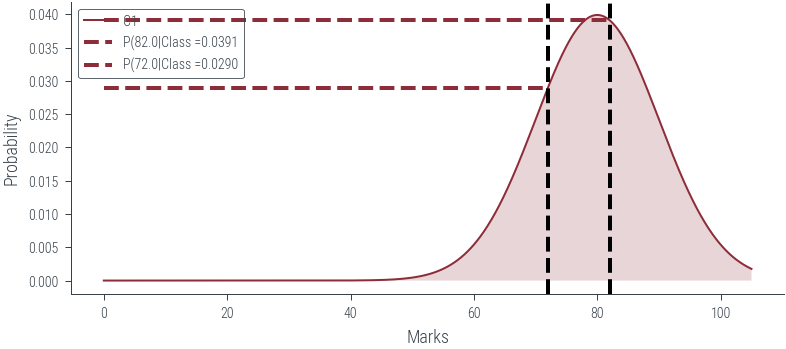

In [11]:
# Plot the distributions
def plot_class(class_num):
    x = torch.linspace(0, 105, 1000)
    dist = [c1, c2, c3][class_num-1]
    plt.plot(x, dist.log_prob(x).exp(), label=f'C{class_num}')
    plt.fill_between(x, dist.log_prob(x).exp(), alpha=0.2)


    plt.xlabel('Marks')
    plt.ylabel('Probability')

    #plt.legend(title='Class')
    #plt.savefig('../figures/mle/mle-example.pdf', bbox_inches='tight')

    # Vertical line at x = 82
    marks = torch.tensor([82., 72.0])
    for mark in marks:
        plt.axvline(mark.item(), color='k', linestyle='--', lw=2)

        plt.hlines(dist.log_prob(mark).exp(), 0, mark.item(), color='C0', linestyle='--', lw=2, label=f"P({mark.item()}|Class ={dist.log_prob(mark).exp().item():0.4f}")
        #plt.hlines(c2.log_prob(mark).exp(), 0, mark.item(), color='C1', linestyle='--', lw=2)
        #plt.hlines(c3.log_prob(mark).exp(), 0, mark.item(), color='C2', linestyle='--', lw=2)
    #plt.savefig('../figures/mle/mle-example-2.pdf', bbox_inches='tight')
    plt.legend()
    #plt.savefig("..")

plot_class(1)

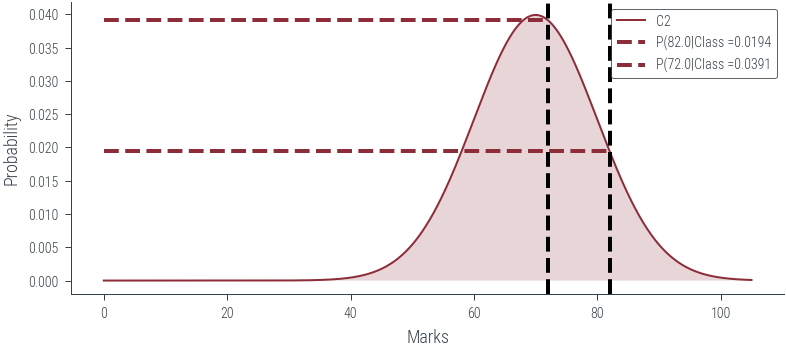

In [12]:
plot_class(2)

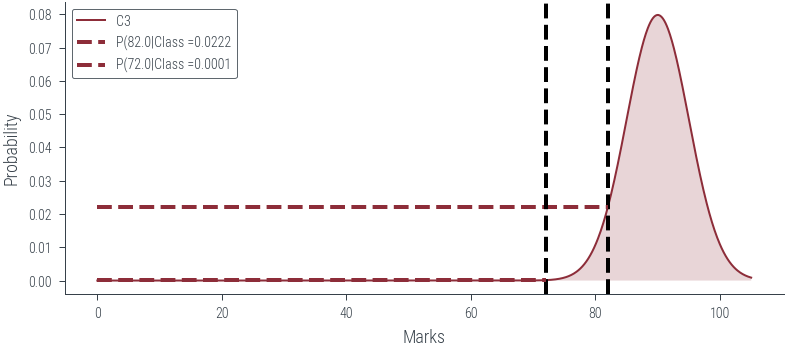

In [13]:
plot_class(3)

In [14]:
#
s1 = torch.tensor([82.0])
s2 = torch.tensor([72.0])

p_s1_c1 = c1.log_prob(s1).exp()
p_s1_c2 = c2.log_prob(s1).exp()
p_s1_c3 = c3.log_prob(s1).exp()

p_s2_c1 = c1.log_prob(s2).exp()
p_s2_c2 = c2.log_prob(s2).exp()
p_s2_c3 = c3.log_prob(s2).exp()

# Create dataframe
df = pd.DataFrame({
    'Class': ['C1', 'C2', 'C3'],
    'Student 1 (82)': [p_s1_c1.item(), p_s1_c2.item(), p_s1_c3.item()],
    'Student 2 (72)': [p_s2_c1.item(), p_s2_c2.item(), p_s2_c3.item()]
})

df = df.set_index('Class')
df

,Student 1 (82),Student 2 (72)
Class,,
C1,0.039104,0.028969
C2,0.019419,0.039104
C3,0.022184,0.000122


<AxesSubplot:xlabel='Class'>

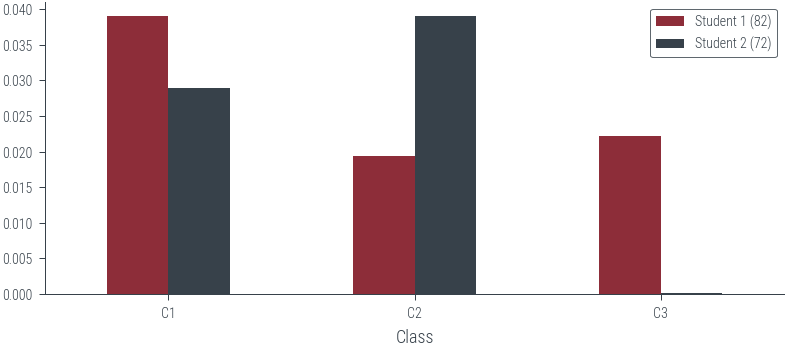

In [15]:
df.plot(kind='bar', rot=0)

In [16]:
# Multiply the probabilities
df.aggregate('prod', axis=1)


Class
C1    0.001133
C2    0.000759
C3    0.000003
dtype: float64

<AxesSubplot:xlabel='Class'>

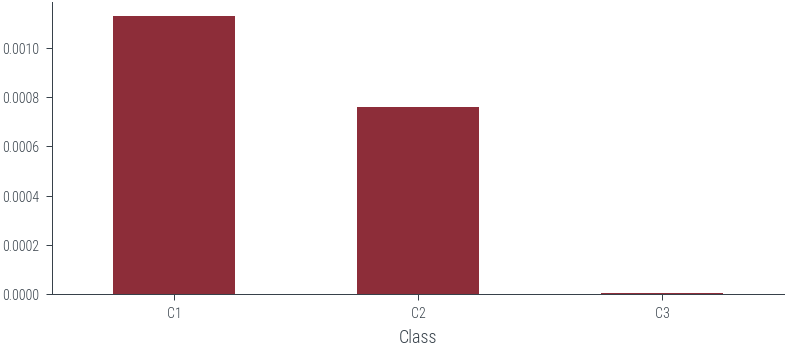

In [17]:
df.aggregate('prod', axis=1).plot(kind='bar', rot=0)

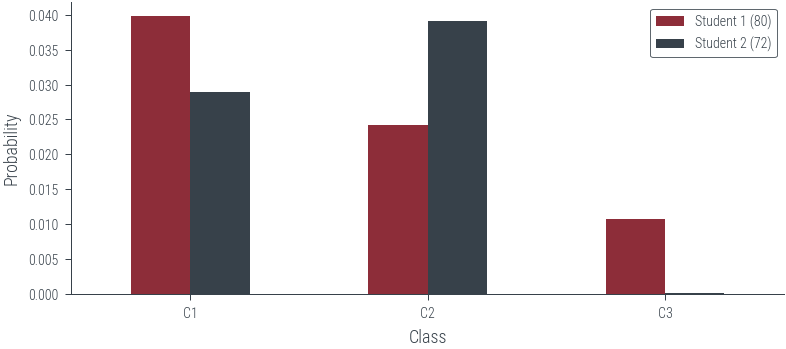

In [18]:
# Create a slider to change s1 and s2 marks and plot the likelihood


def plot_likelihood(s1, s2, scale='log'):
    s1 = torch.tensor([s1])
    s2 = torch.tensor([s2])
    p_s1_c1 = c1.log_prob(s1)
    p_s1_c2 = c2.log_prob(s1)
    p_s1_c3 = c3.log_prob(s1)

    p_s2_c1 = c1.log_prob(s2)
    p_s2_c2 = c2.log_prob(s2)
    p_s2_c3 = c3.log_prob(s2)


    # Create dataframe
    df = pd.DataFrame({
        'Class': ['C1', 'C2', 'C3'],
        f'Student 1 ({s1.item()})': [p_s1_c1.item(), p_s1_c2.item(), p_s1_c3.item()],
        f'Student 2 ({s2.item()})': [p_s2_c1.item(), p_s2_c2.item(), p_s2_c3.item()]
    })
    
    

    df = df.set_index('Class')
    if scale!='log':
        df  = df.apply(np.exp)
    df.plot(kind='bar', rot=0)
    plt.ylabel('Probability')
    plt.xlabel('Class')

    if scale=='log':
        plt.ylabel('Log Probability')
        #plt.yscale('log')

plot_likelihood(80, 72, scale='linear')

    

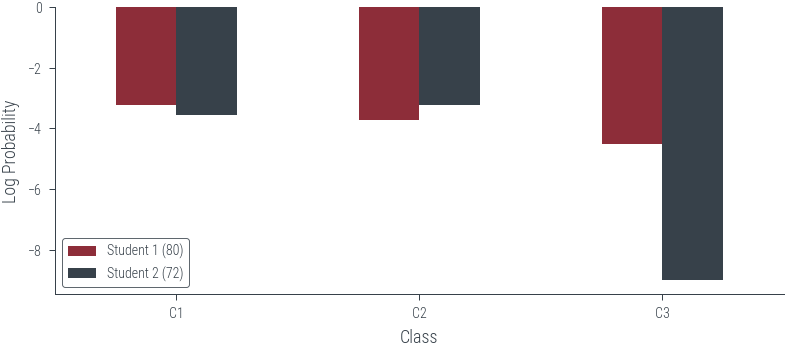

In [19]:
plot_likelihood(80, 72, scale='log')


In [20]:
# Interactive plot
interact(plot_likelihood, s1=(0, 100), s2=(0, 100), scale=['linear', 'log'])

interactive(children=(IntSlider(value=50, description='s1'), IntSlider(value=50, description='s2'), Dropdown(d…

<function __main__.plot_likelihood(s1, s2, scale='log')>

In [33]:
# Let us now consider some N points from a univariate Gaussian distribution with mean 0 and variance 1.

N = 50
torch.manual_seed(2)
samples = torch.distributions.Normal(0, 1).sample((N,))
samples
samples.mean(), samples.std(correction=0)

(tensor(-0.0089), tensor(1.0376))

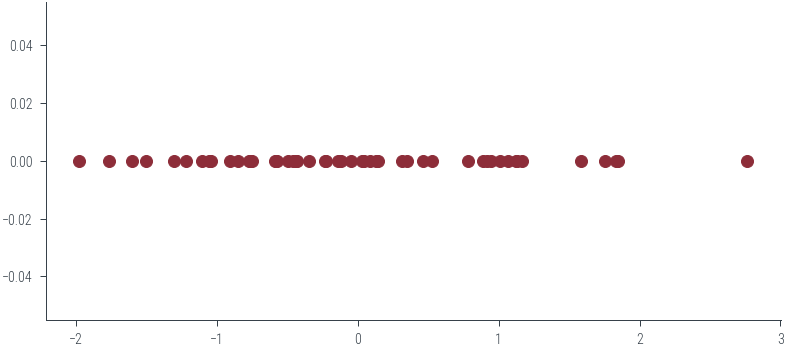

In [34]:
plt.scatter(samples, np.zeros_like(samples))

In [35]:
dist = torch.distributions.Normal(0, 1)
dist.log_prob(samples)

tensor([-1.4606, -1.3390, -1.7694, -1.5346, -1.6616, -1.6006, -1.4780, -0.9260,
        -1.3310, -0.9785, -1.0821, -0.9466, -1.4266, -1.2024, -0.9443, -1.0125,
        -2.0547, -1.0241, -1.2785, -1.0576, -0.9194, -0.9202, -1.4861, -1.3115,
        -1.0266, -1.0433, -0.9272, -4.7362, -0.9288, -1.5451, -0.9686, -2.4551,
        -1.2115, -2.5932, -2.2046, -2.6290, -0.9199, -2.1755, -1.0937, -1.5588,
        -1.3670, -2.4799, -1.0891, -1.0160, -2.8774, -1.2221, -1.2191, -0.9287,
        -0.9790, -0.9227])

In [36]:
def ll(mu, sigma):
    mu = torch.tensor(mu)
    sigma = torch.tensor(sigma)

    dist = torch.distributions.Normal(mu, sigma)
    loglik = dist.log_prob(samples).sum()
    return dist, loglik

def plot_normal(mu, sigma):
    xs = torch.linspace(-5, 5, 100)
    dist, loglik = ll(mu, sigma)
    ys_log = dist.log_prob(xs)
    plt.plot(xs, ys_log)

    plt.scatter(samples, dist.log_prob(samples), color='C3', alpha=0.5)
    plt.title(f'log likelihood: {loglik:.8f}')
   

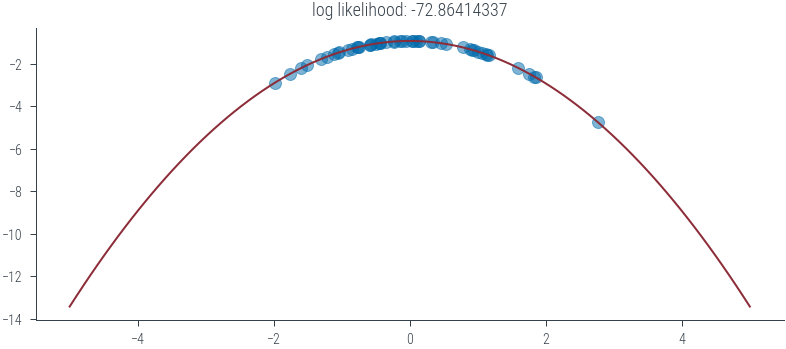

In [37]:
plot_normal(0, 1)
#plt.ylim(-1.7, -1.6)

In [38]:
interact(plot_normal, mu=(-3.0, 3.0), sigma=(0.1, 10))

interactive(children=(FloatSlider(value=0.0, description='mu', max=3.0, min=-3.0), FloatSlider(value=5.05, des…

<function __main__.plot_normal(mu, sigma)>

In [39]:
def get_lls(mus, sigmas):

    lls = torch.zeros((len(mus), len(sigmas)))
    for i, mu in enumerate(mus):
        for j, sigma in enumerate(sigmas):

            lls[i, j] = ll(mu, sigma)[1]
    return lls

mus = torch.linspace(-1, 1, 100)
sigmas = torch.linspace(0.1, 1.5, 100)
lls = get_lls(mus, sigmas)

/tmp/ipykernel_444491/3787141935.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mu = torch.tensor(mu)
/tmp/ipykernel_444491/3787141935.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigma = torch.tensor(sigma)


In [40]:
pd.DataFrame(lls.numpy(), index=mus.numpy(), columns=sigmas.numpy())

,0.100000,0.114141,0.128283,0.142424,0.156566,0.170707,0.184848,0.198990,0.213131,0.227273,...,1.372727,1.386869,1.401010,1.415151,1.429293,1.443434,1.457576,1.471717,1.485859,1.500000
-1.000000,-5077.877930,-3888.119141,-3070.949951,-2485.914551,-2052.976318,-1723.822998,-1467.891479,-1265.083740,-1101.745483,-968.337524,...,-89.101242,-89.059502,-89.029251,-89.009949,-89.001060,-89.002075,-89.012505,-89.031929,-89.059898,-89.096008
-0.979798,-4978.790039,-3812.062744,-3010.738281,-2437.065918,-2012.553467,-1689.820068,-1438.892090,-1240.059692,-1079.932007,-949.154175,...,-88.575401,-88.544327,-88.524429,-88.515175,-88.516029,-88.526489,-88.546104,-88.574448,-88.611084,-88.655617
-0.959596,-4881.743652,-3737.573975,-2951.766602,-2389.223145,-1972.963379,-1656.517456,-1410.490112,-1215.551025,-1058.567871,-930.365845,...,-88.060394,-88.039780,-88.030014,-88.030586,-88.040977,-88.060699,-88.089317,-88.126389,-88.171516,-88.224297
-0.939394,-4786.737305,-3664.650146,-2894.034424,-2342.386963,-1934.205566,-1623.915161,-1382.685181,-1191.557739,-1037.652710,-911.972656,...,-87.556213,-87.545830,-87.545990,-87.556183,-87.575905,-87.604698,-87.642128,-87.687759,-87.741196,-87.802048
-0.919192,-4693.770996,-3593.292969,-2837.542480,-2296.556152,-1896.280029,-1592.012939,-1355.477539,-1168.079590,-1017.187012,-893.974426,...,-87.062874,-87.062485,-87.072350,-87.091965,-87.120834,-87.158508,-87.204544,-87.258545,-87.320107,-87.388863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.919192,-4775.875488,-3656.313477,-2887.434814,-2337.032471,-1929.774536,-1620.187744,-1379.506714,-1188.814819,-1035.261719,-909.869873,...,-87.498581,-87.489357,-87.490654,-87.501953,-87.522743,-87.552574,-87.591011,-87.637611,-87.691994,-87.753777
0.939394,-4870.645508,-3729.055664,-2945.022949,-2383.752197,-1968.436035,-1652.709229,-1407.242188,-1212.748413,-1056.124878,-928.217346,...,-88.001511,-87.982071,-87.973473,-87.975166,-87.986656,-88.007431,-88.037086,-88.075157,-88.121246,-88.174980
0.959596,-4967.457520,-3803.364014,-3003.851562,-2431.478760,-2007.930176,-1685.930908,-1435.575439,-1237.197510,-1077.437134,-946.959961,...,-88.515259,-88.485413,-88.466705,-88.458580,-88.460556,-88.472092,-88.492760,-88.522125,-88.559746,-88.605247
0.979798,-5066.307617,-3879.238281,-3063.919678,-2480.210938,-2048.256348,-1719.852661,-1464.505371,-1262.161865,-1099.198608,-966.097595,...,-89.039841,-88.999352,-88.970322,-88.952187,-88.944420,-88.946533,-88.958046,-88.978508,-89.007492,-89.044586


/tmp/ipykernel_444491/1128417763.py:44: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


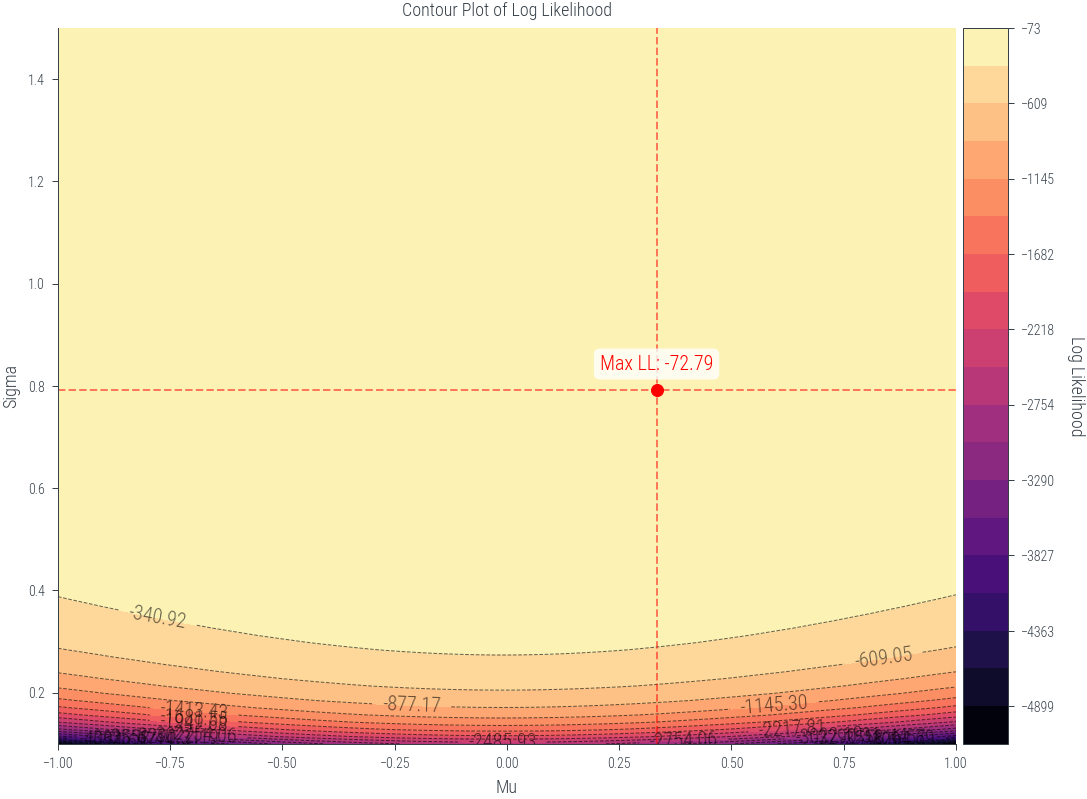

In [41]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_lls(mus, sigmas, lls):
    fig, ax1 = plt.subplots(figsize=(8, 6))
    
    X, Y = np.meshgrid(mus, sigmas)
    
    max_indices = np.unravel_index(np.argmax(lls), lls.shape)
    max_mu = mus[max_indices[1]]
    max_sigma = sigmas[max_indices[0]]
    max_loglik = lls[max_indices]

    # Define levels with increasing granularity
    levels_low = np.linspace(lls.min(), max_loglik, 20)
    levels_high = np.linspace(max_loglik + 0.001, lls.max(), 10)  # Adding a small value to prevent duplicates
    levels = levels_low
    
    # Plot the contour filled plot
    contour = ax1.contourf(X, Y, lls.T, levels=levels, cmap='magma')
    
    # Plot the contour lines
    contour_lines = ax1.contour(X, Y, lls.T, levels=levels, colors='black', linewidths=0.5, alpha=0.6)
    
    # Add contour labels
    ax1.clabel(contour_lines, inline=True, fontsize=10, colors='black', fmt='%1.2f')
    
    ax1.set_xlabel('Mu')
    ax1.set_ylabel('Sigma')
    ax1.set_title('Contour Plot of Log Likelihood')
    
    # Add maximum log likelihood point as scatter on the contour plot
    ax1.scatter([max_mu], [max_sigma], color='red', marker='o', label='Maximum Log Likelihood')
    ax1.annotate(f'Max LL: {max_loglik:.2f}', (max_mu, max_sigma), textcoords="offset points", xytext=(0,10), ha='center', fontsize=10, color='red', bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.3'))

    ax1.axvline(max_mu, color='red', linestyle='--', alpha=0.5)
    ax1.axhline(max_sigma, color='red', linestyle='--', alpha=0.5)
    
    # Create colorbar outside the plot
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(contour, cax=cax)
    cbar.set_label('Log Likelihood', rotation=270, labelpad=15)
    
    plt.tight_layout()
    plt.show()

plot_lls(mus, sigmas, lls)


In [32]:
samples.mean(), samples.std(correction=0)

(tensor(-0.0089), tensor(1.0376))

/tmp/ipykernel_444491/3787141935.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mu = torch.tensor(mu)
/tmp/ipykernel_444491/3787141935.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sigma = torch.tensor(sigma)
/tmp/ipykernel_444491/1128417763.py:44: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


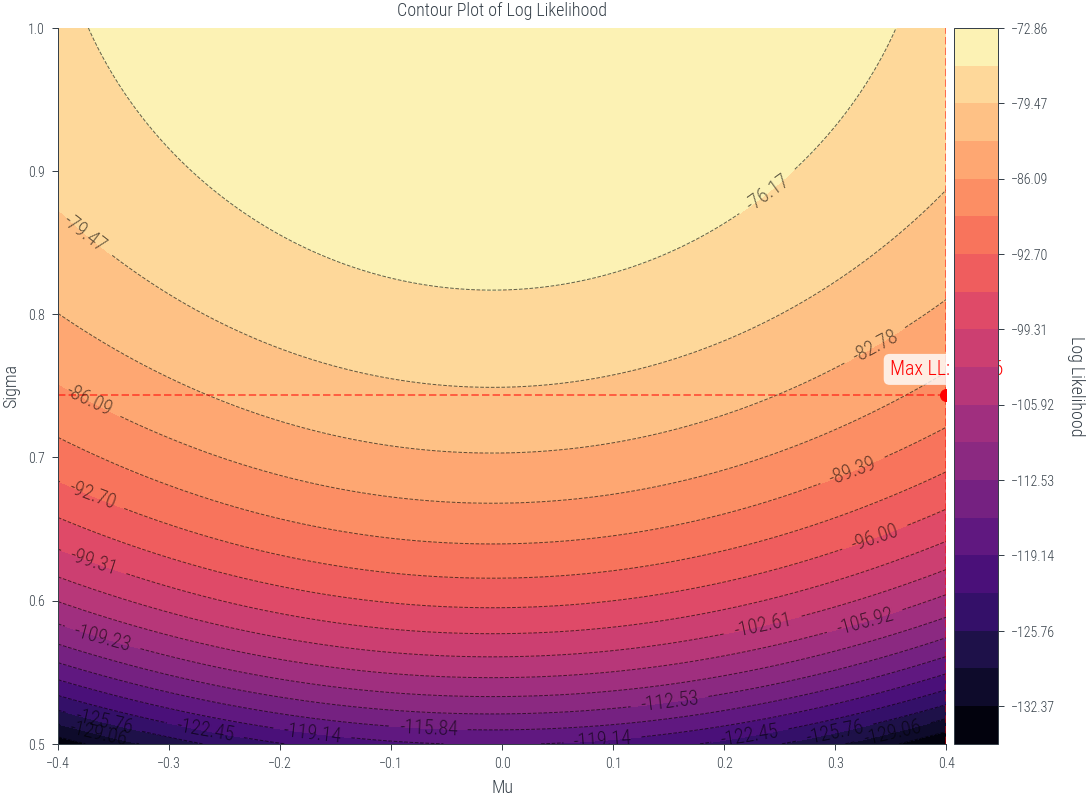

In [42]:
mus = torch.linspace(-0.4, 0.4, 200)
sigmas = torch.linspace(0.5, 1.0,200)
lls = get_lls(mus, sigmas)
plot_lls(mus, sigmas, lls)